In [22]:
import sys 
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm/src/neuralssm')
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm/src/neuralssm/datasets/maf_data')

from flax import nnx # type: ignore
import jax.numpy as jnp # type: ignore
import numpy as onp # type: ignore
import jax.random as jr # type: ignore
import jax # type: ignore
import matplotlib.pyplot as plt # type: ignore
import optax # type: ignore
from density_models import MAF
from datasets.data_loaders import get_data, get_data_loaders, Data

## Generate Data

In [23]:
def generate_data_curved(key, n_samples):
  keys = jr.split(key, 2)
  epsilon = jr.normal(keys[0], shape=(n_samples, ))
  x = jr.uniform(keys[1], (n_samples, ), minval=-10.5, maxval=10.5)
  y = 7*jnp.sin(0.75*x) + 0.5*x + epsilon
  return jnp.array([x, y])

def generate_data_nl_gaussian(key, n_samples):
  keys = jr.split(key, 2)
  u  = jr.normal(keys[0], shape=(n_samples, 2))
  x = 2 * u[:, 0]
  y = x ** 2 / 4 + u[:, 1]
  return jnp.array([y, x])

def generate_linear_data(key, n_samples):
  keys = jr.split(key, 2)
  x = jr.uniform(keys[0], (n_samples, ), minval=-10.5, maxval=10.5)
  y = -0.5 * x + jr.normal(keys[1], (n_samples, ))
  return jnp.array([x, y])

def generate_circular_data(key, n_samples):
  keys = jr.split(key, 2)
  u = jr.uniform(keys[0], (n_samples, ))
  u1 = 0.1 * jr.normal(keys[1], (n_samples, 2))
  x = 2 * jnp.cos(2 * jnp.pi * u) + u1[:, 0]
  y = 2 * jnp.sin(2 * jnp.pi * u) + u1[:, 1]
  return jnp.array([x, y])

dataset = '2D'

if dataset == '2D':
  ntrain = 50000 # just use train everything in a batch
  nval = 10000
  ntest = 10000
  gen = generate_data_nl_gaussian
  keys = jr.split(jr.PRNGKey(0), 3)
  all_data = onp.array(gen(keys[0], ntrain + nval + ntest).T)
  train_data = all_data[:ntrain]
  val_data = all_data[ntrain:ntrain+nval]
  test_data = all_data[ntrain+nval:]
  all_data =  all_data[:, ::-1]
  data = Data(all_data.shape[1], train_data, val_data, test_data)
  input_dim = data.n_dims
  din = input_dim
  dcond = input_dim - din 
elif dataset == 'mnist':
  data = get_data('mnist')
  input_dim = data.n_dims
  din = input_dim
  dcond = input_dim - din 
elif dataset == 'cond_mnist':
  data = get_data('mnist')
  train_data = onp.array(jnp.concatenate([jax.nn.one_hot(data.train.labels, 10), data.train.x], axis=1))
  val_data = onp.array(jnp.concatenate([jax.nn.one_hot(data.val.labels, 10), data.val.x], axis=1))
  test_data = onp.array(jnp.concatenate([jax.nn.one_hot(data.test.labels, 10), data.test.x], axis=1))
  data = Data(794, train_data, val_data, test_data)
  input_dim = data.n_dims
  din = 784
  dcond = input_dim - din 


batch_size = 128
train_loader, val_loader, test_loader  = get_data_loaders(data, batch_size)
# # plot the original data and the test data
# plt.figure(figsize=(3, 3))
# plt.scatter(data[:,0], data[:,1], alpha=0.2)
# plt.show()

## MAF development

### Training

In [ ]:
key1, key2 = jr.split(jr.PRNGKey(10))

##### Search-relevant hyperparameters #########
reverse = True
random_order = False
batch_norm = False
dropout = False
nmades = 5
dhidden = 512
nhidden = 5
num_epochs = 20
learning_rate = 1 * 1e-4
###############################################
model = MAF(din, nmades, dhidden, nhidden, dcond, nnx.Rngs(0), random_order, reverse, batch_norm, dropout)
# model = OMAF(din, nmades, dhidden, nhidden, nnx.Rngs(0), random_order, reverse, batch_norm, dropout)
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, weight_decay=1e-6)) 

@nnx.jit  # automatic state management
def train_step(model, optimizer, data):
  loss_fn = lambda model: model.loss_fn(data)
  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # inplace updates
  return loss

#### TRAINING LOOP
train_losses = []
val_losses = []
keys = jr.split(key1, num_epochs)
for i in range(num_epochs):
  key, subkey = jr.split(keys[i])
  model.train()
  train_loss = []
  val_loss = []
  model.train()
  for batch in train_loader:
      batch = jnp.array(batch)
      loss = train_step(model, optimizer, batch)
      train_loss.append(loss)
  model.eval()
  for batch in val_loader:
      batch = jnp.array(batch)
      loss = model.loss_fn(batch)
      val_loss.append(loss)

  train_loss = jnp.mean(jnp.array(train_loss))
  val_loss = jnp.mean(jnp.array(val_loss))
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print(f"Epoch {i}, training loss: {train_loss}, validation loss: {val_loss}")

Epoch 0, training loss: 3.5502700805664062, validation loss: 3.557152271270752


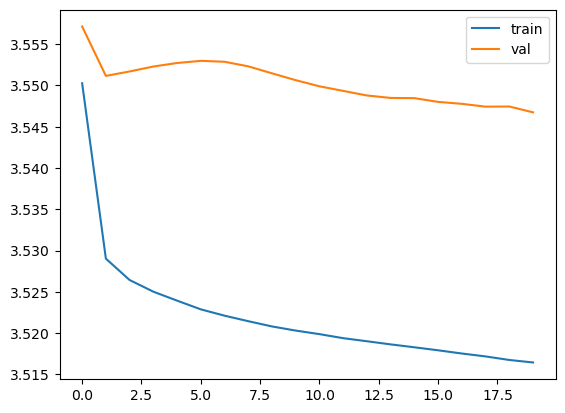

In [14]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

In [15]:
model.eval()
if dataset == '2D':
    num_gen_samples = 10000
    sample = model.generate(key2, num_gen_samples, data.val[:num_gen_samples, :dcond])
elif dataset == 'mnist':
    num_gen_samples = 200
    sample = model.generate(key2, num_gen_samples, data.val.x[:num_gen_samples, :dcond])
elif dataset == 'cond_mnist':
    num_gen_samples = 20
    label = 5
    # cond_labels = jax.nn.one_hot(jnp.repeat(jnp.array(label), num_gen_samples), 10) # all labels equal to label
    cond_labels = data.val[:num_gen_samples, :dcond] # labels from train dataset
    sample = model.generate(key2, num_gen_samples, cond_labels)


In [16]:
# for i in range(num_gen_samples):
#     sample0 = sample[i][10:]
#     perc = jnp.percentile(sample[i][10:], 85)
#     sample0 = jnp.where(sample0>perc, sample0, 0)
#     sample0 /= jnp.max(sample0)
#     plt.imshow(sample0.reshape(28, 28), cmap='gray')
#     plt.colorbar()
#     plt.show()

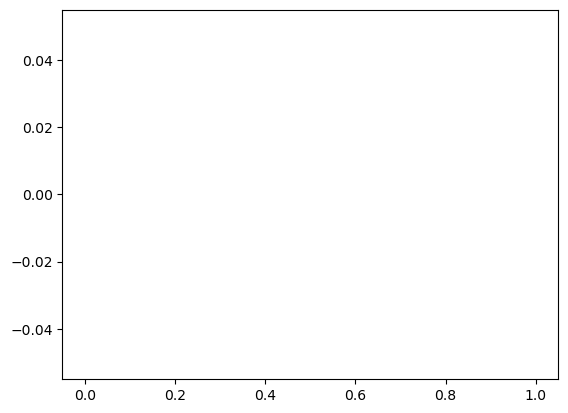

In [17]:
plt.hist(sample[10][10:], bins = 100)
plt.show()

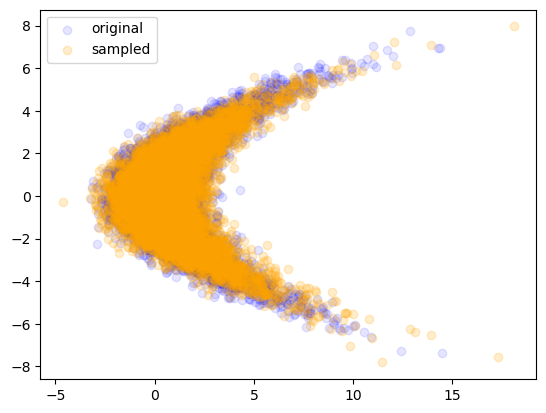

In [18]:
if dataset == '2D':
    plt.scatter(data.val[:, 0], data.val[:, 1], alpha=0.1, color = 'blue', label='original')
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.2, color='orange', label='sampled')
    plt.legend()
    plt.show()
if dataset == 'mnist':
    for i in range(num_gen_samples):
        plt.imshow(sample[i].reshape(28, 28), cmap='gray')
        plt.show()
if dataset == 'cond_mnist':
    for i in range(num_gen_samples):
        print(jnp.argwhere(sample[i, :10] == 1))
        plt.imshow(sample[i, 10:].reshape(28, 28), cmap='gray')
        plt.show()

# SSM dataset

In [1]:
import jax # type: ignore
from jax import numpy as jnp # type: ignore
from jax import random as jr # type: ignore
import blackjax # type: ignore
import jax.scipy.stats as jss # type: ignore
from jax.scipy.special import logsumexp as lse # type: ignore
from dynamax.utils.bijectors import RealToPSDBijector # type: ignore
import numpy as onp # type: ignore
from jax import vmap # type: ignore
from jax.tree_util import tree_map # type: ignore

from utils import reshape_emissions
from density_models import MAF
from flax import nnx # type: ignore
from matplotlib import pyplot as plt # type: ignore
from parameters import params_from_tree, sample_ssm_params, initialize, to_train_array, log_prior, get_unravel_fn, join_trees, tree_from_params
import tensorflow_probability.substrates.jax.distributions as tfd # type: ignore
import tensorflow_probability.substrates.jax.bijectors as tfb # type: ignore
from simulation_inference import sample_and_train
from ssm import SV, LGSSM
from filters import bpf
import optax # type: ignore

import csv
import time
from datasets.data_loaders import Data, get_data_loaders 

import scienceplots # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib_inline # type: ignore
plt.style.use(['science', 'ieee'])
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from output_utils import true_loglik

In [2]:
## Define experiment parameters
num_timesteps = 100 # Number of emissions timesteps
num_mcmc_steps = 1000 # Number of MCMC steps
num_reps = 100 # number of experiment reps

lag = 10 # Number of emissions to condition on
num_samples = 50 # Number of samples for TAF training
num_rounds = 1 # Number of rounds of TAF training

num_particles = 10 # Number of particles for BPF
num_iters = 1 # Number of iterations for BPF likelihood estimator

rw_sigma = 0.1 # Random walk proposal sigma (don't tune)
## Define SV parameters
state_dim = 1
emission_dim = state_dim
input_dim = 0

initial_mean = jnp.zeros(state_dim)
initial_covariance = jnp.eye(state_dim) * 1.0

dynamics_weights  = 0.91 * jnp.eye(state_dim)
dynamics_bias = jnp.zeros(state_dim)
dynamics_input_weights = jnp.zeros((state_dim, input_dim))
dynamics_covariance = jnp.eye(state_dim) * 1.0

emission_bias = jnp.zeros(emission_dim)
emission_covariance = jnp.eye(emission_dim) * 1.0
emission_beta = jnp.array([0.3])
emission_sigma = jnp.array([[2.0]]) 

# Initialize params and props
m = state_dim * (state_dim + 1) // 2
dynamics_covariance_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(m), scale_diag=jnp.ones(m))
ell = emission_dim * (emission_dim + 1) // 2
emission_sigma_dist = tfd.MultivariateNormalDiag(loc=0.3*jnp.ones(ell), scale_diag=0.1*jnp.ones(ell))

param_names = [['mean', 'cov'],
               ['weights', 'bias', 'input_weights', 'cov'],
               ['bias', 'cov', 'beta', 'sigma']]

prior_fields = [[initial_mean, initial_covariance],
                [dynamics_weights, dynamics_bias, dynamics_input_weights, dynamics_covariance],
                [emission_bias, emission_covariance, emission_beta, emission_sigma_dist]]

is_constrained_tree = [[True, True], 
                       [True, True, True, True], 
                       [True, True, True, False]]

constrainers  = [[None, RealToPSDBijector],
                [None, None, None, RealToPSDBijector],
                [None, RealToPSDBijector, None, RealToPSDBijector]]

props, prior = initialize(prior_fields, param_names, constrainers)

seed = 121241378123  
key = jr.PRNGKey(seed)  
taf_error_array = jnp.zeros(num_reps)
bpf_error_array = jnp.zeros(num_reps)

In [3]:
# Sample ***true*** params and emissions
key, subkey = jr.split(key)
svmodel = SV(state_dim, emission_dim)
[true_params, example_params] = sample_ssm_params(key, prior, 2)
true_param_vec = to_train_array(true_params, props)
true_params.from_unconstrained(props)
_, emissions = svmodel.simulate(subkey, true_params, num_timesteps)

In [4]:
din = emission_dim * num_timesteps
n_params = to_train_array(example_params, props).shape[0]
dcond = n_params
reverse = True
random_order = False
batch_norm = False
dropout = False
nmades = 5
dhidden = 32
nhidden = 5
maf = MAF(din, nmades, dhidden, nhidden, dcond, nnx.Rngs(0), random_order, reverse, batch_norm, dropout)
test_sv_model = SV(state_dim, emission_dim)

## Sample parameters for first round
key, subkey = jr.split(key)
params_sample = sample_ssm_params(subkey, prior, num_samples)

In [49]:
from functools import partial
def f(a, b):
    return a**b

fa = partial(f, b=2)
fa(2)

4

In [13]:
from utils import reshape_emissions, map_sims
prev_dataset = jnp.array([])
verbose = True

num_samples = len(params_sample)
keys = jr.split(key, num_samples)
all_cond_params = jnp.array(tree_map(lambda params: to_train_array(params, props), params_sample))
all_emissions = vmap(map_sims, in_axes=(0,0,None,None,None,None))(keys, all_cond_params, props, example_params, test_sv_model, num_timesteps)
dataset = jnp.concatenate([all_cond_params, all_emissions], axis=1)
dataset = onp.array(dataset.reshape(-1, dataset.shape[-1]))
if prev_dataset.shape == (0,):
    prev_dataset = onp.empty((0, dataset.shape[1]))
new_dataset = onp.concatenate([prev_dataset, dataset], axis=0)

TypeError: Cannot concatenate arrays with different numbers of dimensions: got (50, 1), (50, 100, 1).

In [22]:
aa = jnp.concatenate([all_emissions,all_emissions, all_emissions], axis=2)
print(aa.shape)
aa.reshape(num_samples, -1).shape

(50, 100, 3)


(50, 300)

In [ ]:
all

In [6]:
def train_step(model, optimizer, data):
    loss_fn = lambda model: model.loss_fn(data)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # inplace updates
    return loss

In [7]:
batch_size = 128
num_epochs = 20
learning_rate = 1 * 1e-3
weight_decay = 1e-6
#### Setup data loaders
if verbose:
    print("----Setting up data loaders")
ntrain, nval = int(0.95 * new_dataset.shape[0]), int(0.05 * new_dataset.shape[0])
train_data, val_data, test_data = new_dataset[:ntrain], new_dataset[ntrain:ntrain+nval], new_dataset[ntrain+nval:]
data = Data(new_dataset.shape[1], train_data, val_data, test_data)
train_loader, val_loader, _  = get_data_loaders(data, batch_size)

##### Set up trainer
optimizer = nnx.Optimizer(maf, optax.adamw(learning_rate, weight_decay=1e-6)) 

#### TRAINING LOOP
if verbose:
    print("----Start training loop")
train_losses = []
val_losses = []
for i in range(num_epochs):
    maf.train()
    train_loss = []
    val_loss = []
    maf.train()
    for batch in train_loader:
        batch = jnp.array(batch)
        loss = train_step(maf, optimizer, batch)
        train_loss.append(loss)
    maf.eval()
    for batch in val_loader:
        batch = jnp.array(batch)
        loss = maf.loss_fn(batch)
        val_loss.append(loss)
    train_loss = jnp.mean(jnp.array(train_loss))
    val_loss = jnp.mean(jnp.array(val_loss))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if verbose: 
        print(f"--------Epoch {i}, training loss: {train_loss}, validation loss: {val_loss}")

----Setting up data loaders
----Start training loop
--------Epoch 0, training loss: 111.37258911132812, validation loss: -53.89464569091797
--------Epoch 1, training loss: 111.36487579345703, validation loss: -53.904052734375
--------Epoch 2, training loss: 111.357421875, validation loss: -53.909461975097656
--------Epoch 3, training loss: 111.349853515625, validation loss: -53.9154052734375
--------Epoch 4, training loss: 111.34249114990234, validation loss: -53.922584533691406
--------Epoch 5, training loss: 111.3350601196289, validation loss: -53.929840087890625
--------Epoch 6, training loss: 111.32756805419922, validation loss: -53.93614196777344
--------Epoch 7, training loss: 111.31993865966797, validation loss: -53.942138671875
--------Epoch 8, training loss: 111.31208038330078, validation loss: -53.94792175292969
--------Epoch 9, training loss: 111.30406188964844, validation loss: -53.954139709472656
--------Epoch 10, training loss: 111.29573059082031, validation loss: -53.960

### Debugging